## Train a semantic segmentation unet using Pytorch

## Imports

In [1]:
from tifffile import imread
from tqdm import tqdm
from tnia.deeplearning.dl_helper import quantile_normalization
import matplotlib.pyplot as plt
import numpy as np
import torch

from torchvision import transforms
from torchvision.transforms import v2
import torchvision.transforms.functional as TF

raster_geometry not imported.  This is only needed for the ellipsoid rendering in apply_stardist


## Check if GPU is present

In [2]:
cuda_present = torch.cuda.is_available()
ndevices = torch.cuda.device_count()
use_cuda = cuda_present and ndevices > 0
device = torch.device("cuda" if use_cuda else "cpu")  # "cuda:0" ... default device, "cuda:1" would be GPU index 1, "cuda:2" etc
print("number of devices:", ndevices, "\tchosen device:", device, "\tuse_cuda=", use_cuda)

number of devices: 1 	chosen device: cuda 	use_cuda= True


## Set up patch directories

In [25]:
from pathlib import Path
import json

#tnia_images_path = Path("D:/images/tnia-python-images")
tnia_images_path = Path(r'/home/bnorthan/images/tnia-python-images')
parent_path=Path(tnia_images_path / r'imagesc/2024_08_08_2photon_vessel')

patch_path= parent_path / 'patches'

model_path = parent_path / 'model'

if not model_path.exists():
    model_path.mkdir()

with open(patch_path / 'info.json', 'r') as json_file:
    data = json.load(json_file)
    sub_sample = data.get('sub_sample',1)
    print('sub_sample',sub_sample)
    axes = data['axes']
    print('axes',axes)
    num_inputs = data['num_inputs']
    print('num_inputs',num_inputs)
    num_truths = data['num_truths']
    print('num_truths',num_truths)


label_patch_path = patch_path / 'ground truth0'
image_patch_path = patch_path / 'input0'

from glob import glob

tif_files = glob(str(image_patch_path / '*.tif'))

first_im = imread(tif_files[0])
target_shape=first_im.shape

if axes == 'YX':
    num_in_channels=1
else:
    num_in_channels=3


sub_sample 1
axes YXC
num_inputs 1
num_truths 1


## Create a PyTorch Dataset

Dataset is simply used to retrieve the training patches.  In this case we just set it up to read in image files, then convert the numpy arrays to tensors and a torch stack.

In this example augmentation was done in a previous notebook, and the augmented images explicitly saved.  It is also possible to do augmentation as the data is retrieved.  So in the future the ```MyDataSet``` could be extended to apply augmentation as data is retrieved.

In [15]:
class MyDataSet():

    def __init__(self, image_files, label_files_list, target_shape=target_shape):
            """
            Parameters
            ----------
            image_files: list of pathlib.Path objects pointing to the *.tif images
            label_files_list: list of lists of pathlib.Path objects pointing to the *.tif segmentation masks
                        there are mulitple lists of label files each potentially representing one class
            target_shape: tuple of length 2 specifying the sample resolutions of files that
                        will be kept. All other files will NOT be used.
            """
            assert len(image_files) == len(label_files_list[0])
            assert all(x.name==y.name for x,y in zip(image_files, label_files_list[0]))

            self.images = []
            self.labels = []

            tensor_transform = transforms.Compose([
                v2.ToTensor(),
            ])

            # use tqdm to have eye pleasing error bars
            for idx in tqdm(range(len(image_files))):
                # we use the same data reading approach as in the previous notebook
                image = imread(image_files[idx])

                labels = []               
                for label_files in label_files_list:
                    label = imread(label_files[idx])
                    labels.append(label)

                if image.shape != target_shape:
                    continue
                
                # NOTE: we convert the label to dtype float32 and not uint8 because
                # the tensor transformation does a normalization if the input is of
                # dtype uint8, destroying the 0/1 labelling which we want to avoid.
                # label = fill_label_holes(label)
                
                labels_binary = []

                for label in labels:
                    label_binary = np.zeros_like(label).astype(np.float32)
                    label_binary[label != 0] = 1.
                    labels_binary.append(label_binary)

                # convert to torch tensor: adds an artificial color channel in the front
                # and scales inputs to have same size as samples tend to differ in image
                # resolutions
                image = tensor_transform(image)
                labels_binary = np.stack(labels_binary, axis=2)
                label = tensor_transform(labels_binary)

                self.images.append(image)
                self.labels.append(label)

            self.images = torch.stack(self.images)
            self.labels = torch.stack(self.labels)
    
    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

    def __len__(self):
        return len(self.images)

## Initialize the DataSet 

Initialize the DataSet with the pre-generated patch names

In [16]:
print(len(Y[0]))

600


In [17]:
src_dir = patch_path

assert src_dir.exists(), f"root directory with images and masks {src_dir} does not exist"

X = sorted(src_dir.rglob('**/input0/*.tif'))

Y = []
for i in range(num_truths):
    Y.append(sorted(src_dir.rglob(f'**/ground truth{i}/*.tif')))

train_data = MyDataSet(
    image_files=X,
    label_files_list=Y,
    target_shape=target_shape
)

# NOTE: the length of the dataset might not be the same as n_samples
#       because files not having the target shape will be discarded
print(len(train_data))


/home/bnorthan/mambaforge/envs/segment_everything_fresh/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(
100%|██████████| 600/600 [00:02<00:00, 277.75it/s]

600


## Create a DataLoader

This is done so we can load batches of images. 

In [18]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

## Create a UNET

In [19]:
from monai.networks.nets import BasicUNet

model = BasicUNet(
    spatial_dims=2,
    in_channels=num_in_channels,
    out_channels=num_truths,
    #features=[16, 16, 32, 64, 128, 16],
    act="relu",
    norm="batch",
    dropout=0.25,
)

# Important: transfer the model to the chosen device
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1.e-3)
init_params = list(model.parameters())[0].clone().detach()

/home/bnorthan/mambaforge/envs/segment_everything_fresh/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


BasicUNet features: (32, 32, 64, 128, 256, 32).


## Train the UNET

In [20]:
max_nepochs = 20 
log_interval = 20
model.train(True)

# BCEWithLogitsLoss combines sigmoid + BCELoss for better
# numerical stability. It expects raw unnormalized scores as input which are shaped like 
# B x C x W x D
loss_function = torch.nn.BCEWithLogitsLoss(reduction="mean")

for epoch in range(1, max_nepochs + 1):
    for batch_idx, (X, y) in enumerate(train_loader):
        # the inputs and labels have to be on the same device as the model
        X, y = X.to(device), y.to(device)
        
        optimizer.zero_grad()

        prediction_logits = model(X)
        
        batch_loss = loss_function(prediction_logits, y)

        batch_loss.backward()

        optimizer.step()

        if batch_idx % log_interval == 0:
            print(
                "Train Epoch:",
                epoch,
                "Batch:",
                batch_idx,
                "Total samples processed:",
                (batch_idx + 1) * train_loader.batch_size,
                "Loss:",
                batch_loss.item(),
            )

Train Epoch: 1 Batch: 0 Total samples processed: 32 Loss: 0.7054508924484253
Train Epoch: 2 Batch: 0 Total samples processed: 32 Loss: 0.34130775928497314
Train Epoch: 3 Batch: 0 Total samples processed: 32 Loss: 0.304271936416626
Train Epoch: 4 Batch: 0 Total samples processed: 32 Loss: 0.2686168849468231
Train Epoch: 5 Batch: 0 Total samples processed: 32 Loss: 0.2427128404378891
Train Epoch: 6 Batch: 0 Total samples processed: 32 Loss: 0.231131911277771
Train Epoch: 7 Batch: 0 Total samples processed: 32 Loss: 0.2199118286371231
Train Epoch: 8 Batch: 0 Total samples processed: 32 Loss: 0.19240055978298187
Train Epoch: 9 Batch: 0 Total samples processed: 32 Loss: 0.20635870099067688
Train Epoch: 10 Batch: 0 Total samples processed: 32 Loss: 0.1864013671875
Train Epoch: 11 Batch: 0 Total samples processed: 32 Loss: 0.1988498717546463
Train Epoch: 12 Batch: 0 Total samples processed: 32 Loss: 0.15996581315994263
Train Epoch: 13 Batch: 0 Total samples processed: 32 Loss: 0.1739718616008

## Look at self-prediction

Self-prediction does not tell us how the UNET will perform on new data, but it is a useful check to make sure the UNET is learning the training data. 

In [21]:
len(X)
X.shape

torch.Size([24, 3, 256, 256])

torch.Size([24, 1, 256, 256])


Text(0.5, 1.0, 'Prediction 1')

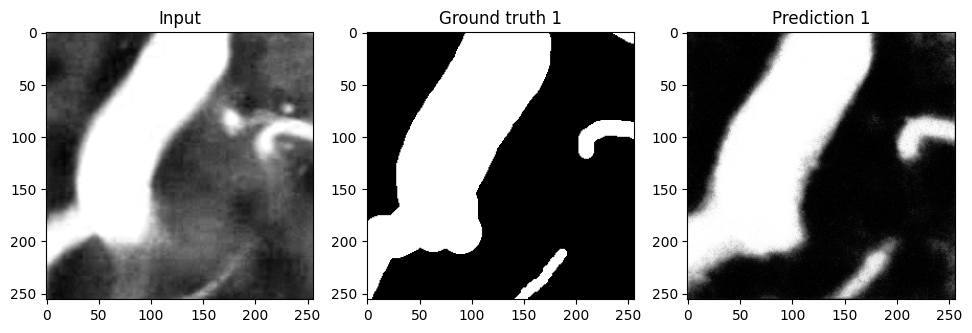

In [22]:
import matplotlib.pyplot as plt

# convert to 0/1 range on each pixel
prediction = torch.nn.functional.sigmoid(prediction_logits)
prediction_binary = prediction #(prediction > 0.5).to(torch.uint8)

print(prediction_binary.shape)

sidx = 1

# make big plot
plt.figure(figsize=(20, 5))
plt.subplot(151)
plt.imshow(X[sidx, 0].cpu().numpy(), cmap="gray")
plt.title("Input")

plt.subplot(152)
plt.imshow(y[sidx, 0].cpu().numpy(), cmap="gray")
plt.title("Ground truth 1")

plt.subplot(153)
plt.imshow(prediction_binary.cpu().detach()[sidx, 0].numpy(), cmap="gray")
plt.title("Prediction 1")


## Save the UNET

In [26]:
torch.save(model, model_path / 'model1')